In [27]:
import pandas as pd
import csv
import numpy as np

In [28]:
csv_path = 'RR-Is(NE).csv'
window_size = 12
error_correction = 0.05

def read_first_column_excel(excel_path):
    # Replace 'your_file.xlsx' with the path to your Excel file
    column_name = 'RR-I(ms):ECG'

    # Read the Excel file
    df = pd.read_excel(excel_path)

    # Select the column
    column_data = df[column_name]
    numerical_data = column_data.apply(pd.to_numeric, errors='coerce')
    numerical_data = numerical_data.dropna()
    
    return numerical_data

# reads any numerical values in the first column of the CSV file
def read_first_column_csv(csv_path):
    # Initialize an empty list to store the first column data
    first_column_data = []

    # Open the CSV file
    with open(csv_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)

        # Loop through each row in the CSV file
        for row in reader:
            # Add the first column of each row to the list if the row is not empty and it's a number
            if row and row[0]:
                try:
                    value = float(row[0])
                    first_column_data.append(value)
                except ValueError:
                    pass

    return first_column_data

rr_data_unfiltered = read_first_column_csv(csv_path)


In [29]:
# filters out rr_data that is num_standard_deviations away from the mean
def filter_data(data, num_standard_deviations):
     mean = np.mean(data)
     std = np.std(data)
     return [x for x in data if (x > mean - num_standard_deviations * std) and (x < mean + num_standard_deviations * std)]
     
rr_data = filter_data(rr_data_unfiltered, 2)


In [30]:
# find the anchor points by checking if x+1 is greater than x, and the percentage change is less than the error correction
def find_anchor_points(data, window):
    anchor_points = []
    for index, _ in enumerate(data[window:], start=window):
        x = data[index-1]
        x_plus_1 = data[index]
        if x_plus_1 > x:
            percentage_change = abs(x_plus_1 - x) / x_plus_1 * 100
            if (percentage_change < error_correction*100):
                anchor_points.append(index)

    return anchor_points

anchor_points = find_anchor_points(rr_data, window_size)


In [31]:
# take the anchor points and creates a window but getting the points to the left and right of the anchor point
def create_windowed_data(data, anchor_points, window):
    windowed_data = []
    for anchor_point in anchor_points:
        windowed_data.append(data[anchor_point-window:anchor_point+window])
    return windowed_data

windowed_data = create_windowed_data(rr_data, anchor_points, window_size)

In [32]:
# finds X(0), X(1), etc..
def calculate_average_windows(windowed_data):
    summed_window = [0]*len(windowed_data[0]) # initialize a list of 0's
    averaged_window = [0]*len(windowed_data[0]) # initialize a list of 0's

    for window in windowed_data:
        for index, value in enumerate(window):
            summed_window[index] = summed_window[index] + float(value)
    
    for index, value in enumerate(summed_window):
        averaged_window[index] = value / len(windowed_data)
    
    return averaged_window

averaged_window = calculate_average_windows(windowed_data)


In [33]:
def calculate_average_deceleration_capacity(data, window):
    dc = (data[window] + data[window+1] - data[window-1] - data[window-2])/4
    return dc

deceleration_capacity = calculate_average_deceleration_capacity(averaged_window, window_size)

Data points filtered out: 82
Calculated deceleration capacity: 0.8411354581673223


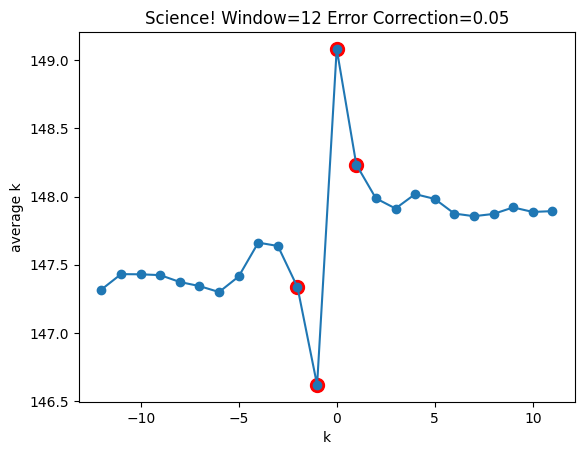

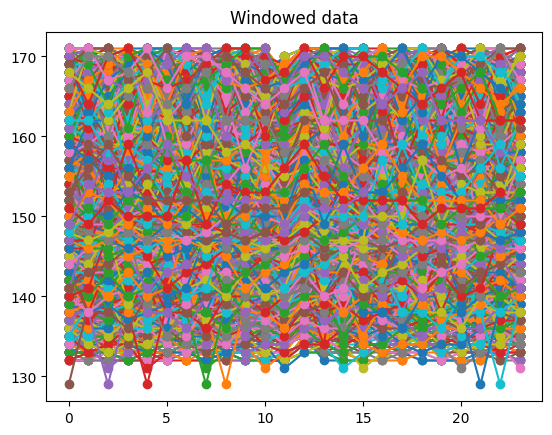

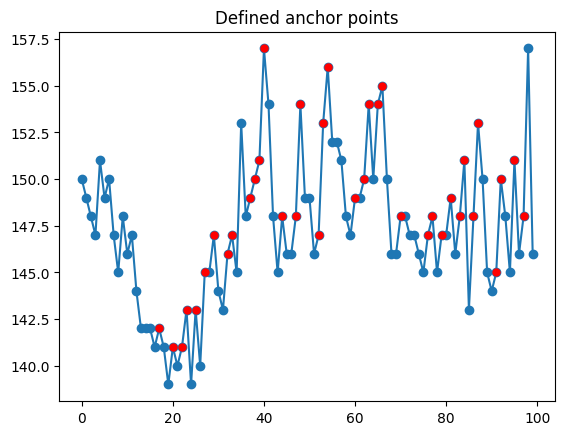

In [34]:
print('Data points filtered out: {}'.format(len(rr_data_unfiltered) - len(rr_data)))

print('Calculated deceleration capacity: {}'.format(deceleration_capacity))

import matplotlib.pyplot as plt 
x_values = range(-window_size, window_size)

highlight_x = []
highlight_y = []
highlight_x.append(0)
highlight_y.append(averaged_window[window_size])
highlight_x.append(1)
highlight_y.append(averaged_window[window_size+1])
highlight_x.append(-1)
highlight_y.append(averaged_window[window_size-1])
highlight_x.append(-2)
highlight_y.append(averaged_window[window_size-2])
plt.plot(highlight_x, highlight_y, linestyle='', marker='o', color='red', markersize=10, label='Highlighted points')  


plt.plot(x_values, averaged_window, marker='o')
plt.xlabel('k')  # Optional: Label for the x-axis
plt.ylabel('average k')  # Optional: Label for the y-axis
plt.title('Science! Window={} Error Correction={}'.format(window_size, error_correction)) 
plt.show()

for data in windowed_data:
    plt.plot(data, marker='o')

plt.title('Windowed data') 
plt.show()

# mark the points we found as anchor points for validation. This is a sanity check.
data_range = 100
rr_subset = rr_data[0:data_range]
highlight_x = []
highlight_y = []
for point in anchor_points:
    if point < data_range:
        highlight_x.append(point)
        highlight_y.append(rr_subset[point])

plt.plot(rr_subset, marker='o')
plt.plot(highlight_x, highlight_y, linestyle='', marker='o', color='red', markersize=5, label='Highlighted points')  
plt.title('Defined anchor points')
plt.show()

In [43]:
# import plotly.express as px

# # Create a line plot
# fig = px.line(x=range(-window_size, window_size), y=averaged_window, title='My Line Plot', markers=True)
# fig.update_traces(marker=dict(size=10, color='Blue', symbol='circle'))

# # Show the plot
# fig.show()